In [299]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import (
    Input,
    ConvLSTM2D,
    LSTM,
    RepeatVector,
    TimeDistributed,
    Dense,
    Dropout,
    LayerNormalization,
    Attention,
    Reshape,
    Flatten,
    Conv1D
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import mlflow.tensorflow
import yfinance as yf
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [300]:
# Configure GPU
def setup_gpu():
    """Configure TensorFlow to use GPU effectively"""
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Memory growth needs to be set before GPUs have been initialized
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Found {len(gpus)} GPU(s): {gpus}")
            print(f"GPU Details: {tf.config.experimental.get_device_details(gpus[0])}")
            return True
        except RuntimeError as e:
            print(f"GPU setup error: {e}")
    else:
        print("No GPU found. Using CPU instead.")
    return False

# Check device availability
has_gpu = setup_gpu()
print(f"TensorFlow Version: {tf.__version__}")
print(f"Devices: {tf.config.list_physical_devices()}")
print(f"Executing eagerly: {tf.executing_eagerly()}")

No GPU found. Using CPU instead.
TensorFlow Version: 2.19.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Executing eagerly: True


In [301]:
print(f"Notebook last run (end-to-end): {datetime.now()}")

Notebook last run (end-to-end): 2025-04-18 18:04:13.964883


In [302]:
# --- Parameters ---
WINDOW_SIZE = 50
FORECAST_HORIZON = 3
BATCH_SIZE = 64
EPOCHS = 200

CRYPTO_SYMBOLS = [
    # Large Cap Coins
    "BTC-USD",    # Bitcoin
    "ETH-USD",    # Ethereum
    "LTC-USD",   # Litecoin

    # Smart Contract Platforms
    # "BNB-USD",    # Binance Coin (BNB Chain)
    # "SOL-USD",    # Solana
    # "ADA-USD",    # Cardano
    # "AVAX-USD",   # Avalanche
    # "TRX-USD",    # TRON

    # Stablecoin
    # "USDC-USD",   # USD Coin (Stablecoin)

    # Meme & Community Tokens
    "DOGE-USD",   # Dogecoin

    # Payments / Layer 1
    # "XRP-USD"     # Ripple (Payments / Banking)
]

EXTERNAL_SYMBOLS = [
    # Commodities
    "GLD",        # Gold ETF
    "SLV",        # Silver ETF
    "CL=F",       # Crude Oil Futures
    "HG=F",       # Copper Futures

    # Equity Indices
    "^GSPC",      # S&P 500
    "^IXIC",      # NASDAQ Composite
    "^DJI",       # Dow Jones Industrial Average

    # Volatility & Rates
    # "^VIX",       # CBOE Volatility Index
    # "^TNX",       # 10-Year Treasury Yield
    # "^IRX",       # 13-Week Treasury Bill Yield

    # Forex & Currency Strength
    # "DXY",        # US Dollar Index
    # "EURUSD=X",   # EUR/USD exchange rate

    # Crypto Market Proxy
    # "COIN"        # Coinbase Global Inc (public crypto proxy)
]

START_DATE = "2017-01-01"
END_DATE = (datetime.now() - timedelta(days=0)).strftime("%Y-%m-%d")

MODEL_DIR = "../models/model.keras"

In [303]:
def fetch_market_data(symbols, start, end):
    dfs = []
    full_idx = pd.date_range(start=start, end=end, freq='D')
    for sym in symbols:
        data = yf.download(sym, start=start, end=end)[['Close', 'Volume']]
        data = data.reindex(full_idx).ffill()
        data.columns = [f"{sym}_Close", f"{sym}_Volume"]
        dfs.append(data)
    df = pd.concat(dfs, axis=1).dropna()
    df.index.name = 'Date'
    return df

In [304]:
price_df = fetch_market_data(CRYPTO_SYMBOLS, START_DATE, END_DATE)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [305]:
price_df

,BTC-USD_Close,BTC-USD_Volume,ETH-USD_Close,ETH-USD_Volume,LTC-USD_Close,LTC-USD_Volume,DOGE-USD_Close,DOGE-USD_Volume
Date,,,,,,,,
2017-11-09,7143.580078,3.226250e+09,320.884003,8.932500e+08,64.269699,279652992.0,0.001415,6259550.0
2017-11-10,6618.140137,5.208250e+09,299.252991,8.859860e+08,59.260101,291596000.0,0.001163,4246520.0
2017-11-11,6357.600098,4.908680e+09,314.681000,8.423010e+08,62.303299,272494016.0,0.001201,2231080.0
2017-11-12,5950.069824,8.957350e+09,307.907990,1.613480e+09,59.005402,322820000.0,0.001038,3288960.0
2017-11-13,6559.490234,6.263250e+09,316.716003,1.041890e+09,61.396500,237478000.0,0.001211,2481270.0
...,...,...,...,...,...,...,...,...
2025-04-14,84542.390625,3.409077e+10,1622.769897,1.651833e+10,77.076431,418704418.0,0.158501,988651639.0
2025-04-15,83668.992188,2.804032e+10,1588.632446,1.317545e+10,75.405632,331081560.0,0.153550,777400544.0
2025-04-16,84033.867188,2.961780e+10,1578.105347,1.533962e+10,74.311646,397457521.0,0.154688,823568608.0


In [306]:
print(price_df.loc["2018-01-01"])

BTC-USD_Close      1.365720e+04
BTC-USD_Volume     1.029120e+10
ETH-USD_Close      7.726410e+02
ETH-USD_Volume     2.595760e+09
LTC-USD_Close      2.290330e+02
LTC-USD_Volume     6.331420e+08
DOGE-USD_Close     8.909000e-03
DOGE-USD_Volume    5.061690e+07
Name: 2018-01-01 00:00:00, dtype: float64


In [307]:
price_df.tail()

,BTC-USD_Close,BTC-USD_Volume,ETH-USD_Close,ETH-USD_Volume,LTC-USD_Close,LTC-USD_Volume,DOGE-USD_Close,DOGE-USD_Volume
Date,,,,,,,,
2025-04-14,84542.390625,3.409077e+10,1622.769897,1.651833e+10,77.076431,418704418.0,0.158501,988651639.0
2025-04-15,83668.992188,2.804032e+10,1588.632446,1.317545e+10,75.405632,331081560.0,0.153550,777400544.0
2025-04-16,84033.867188,2.961780e+10,1578.105347,1.533962e+10,74.311646,397457521.0,0.154688,823568608.0
2025-04-17,84895.750000,2.127687e+10,1582.548340,1.131216e+10,74.880203,326332046.0,0.155740,586169227.0
2025-04-18,84895.750000,2.127687e+10,1582.548340,1.131216e+10,74.880203,326332046.0,0.155740,586169227.0


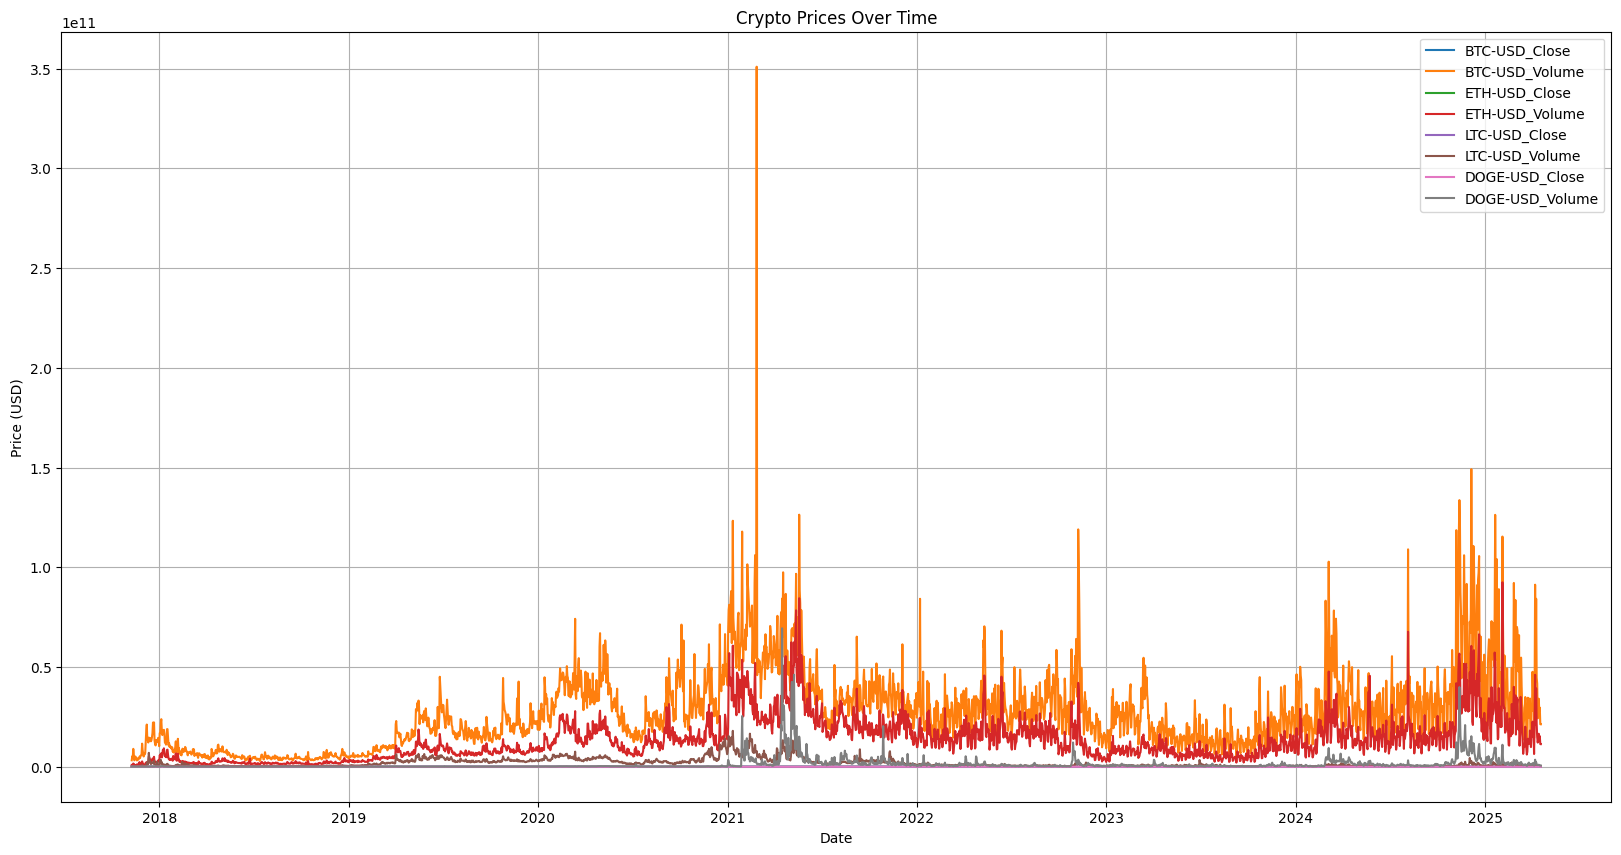

In [308]:

plt.figure(figsize=(20, 10))
for col in price_df.columns:
    plt.plot(price_df[col], label=col)
plt.title("Crypto Prices Over Time")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()



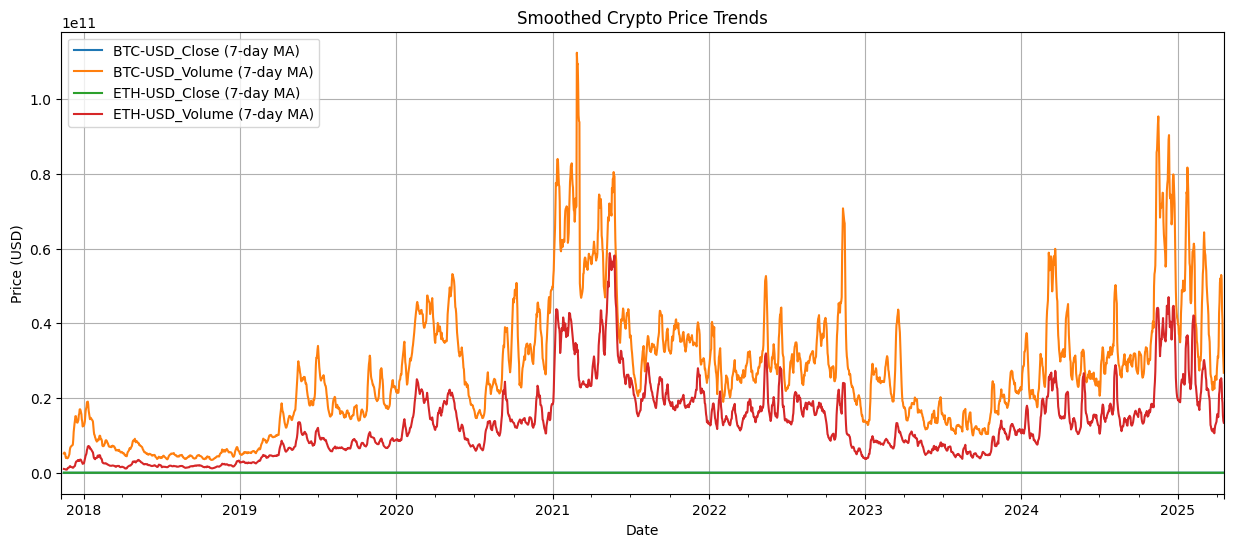

In [309]:
plt.figure(figsize=(15, 6))
for col in price_df.columns[:4]:  # Crypto prices
    price_df[col].rolling(7).mean().plot(label=f"{col} (7-day MA)")
plt.title("Smoothed Crypto Price Trends")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [310]:
btc = yf.Ticker("BTC-USD")
btc_hist = btc.history(start="2018-01-01", end=(datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d"))
btc_hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-12 00:00:00+00:00,83404.515625,85856.187500,82769.375000,85287.109375,24258059104,0.0,0.0
2025-04-13 00:00:00+00:00,85279.468750,86015.187500,83027.007812,83684.976562,28796984817,0.0,0.0
2025-04-14 00:00:00+00:00,83694.523438,85785.000000,83690.640625,84542.390625,34090769777,0.0,0.0
2025-04-15 00:00:00+00:00,84539.695312,86429.351562,83598.820312,83668.992188,28040322885,0.0,0.0
2025-04-16 00:00:00+00:00,83674.507812,85428.281250,83100.617188,84033.867188,29617804112,0.0,0.0


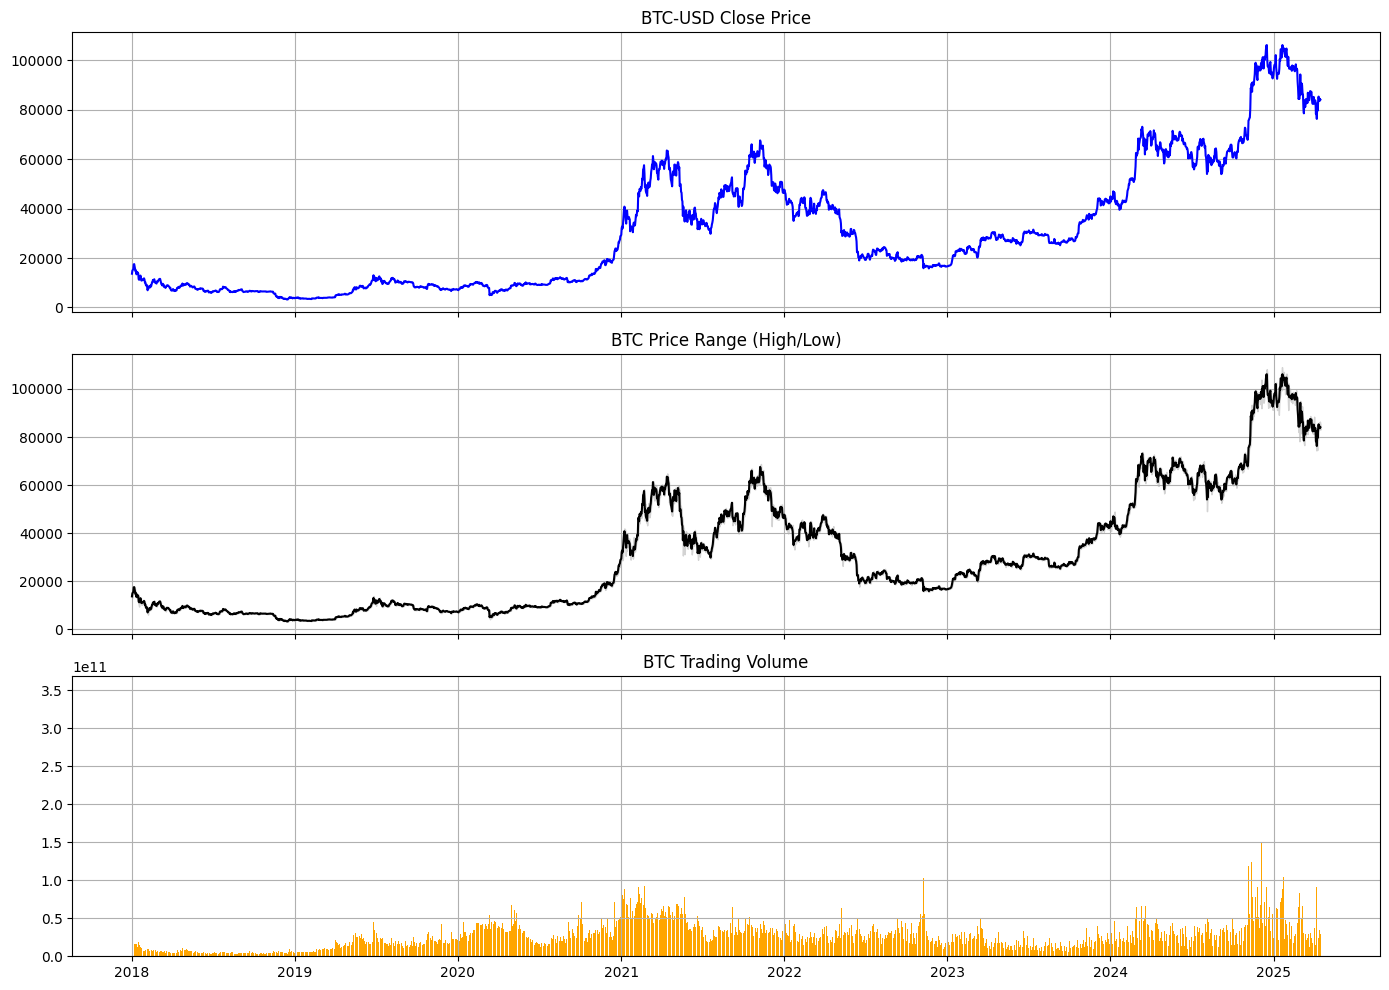

In [311]:
# Plot OHLC + Volume
def plot_btc_full_info(df):
    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    # Close Price
    axs[0].plot(df.index, df["Close"], label="Close", color='blue')
    axs[0].set_title("BTC-USD Close Price")
    axs[0].grid(True)

    # High/Low Range
    axs[1].fill_between(df.index, df["Low"], df["High"], color='lightgray', label="High-Low Range")
    axs[1].plot(df["Close"], label="Close", color='black')
    axs[1].set_title("BTC Price Range (High/Low)")
    axs[1].grid(True)

    # Volume
    axs[2].bar(df.index, df["Volume"], label="Volume", color='orange')
    axs[2].set_title("BTC Trading Volume")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

plot_btc_full_info(btc_hist)

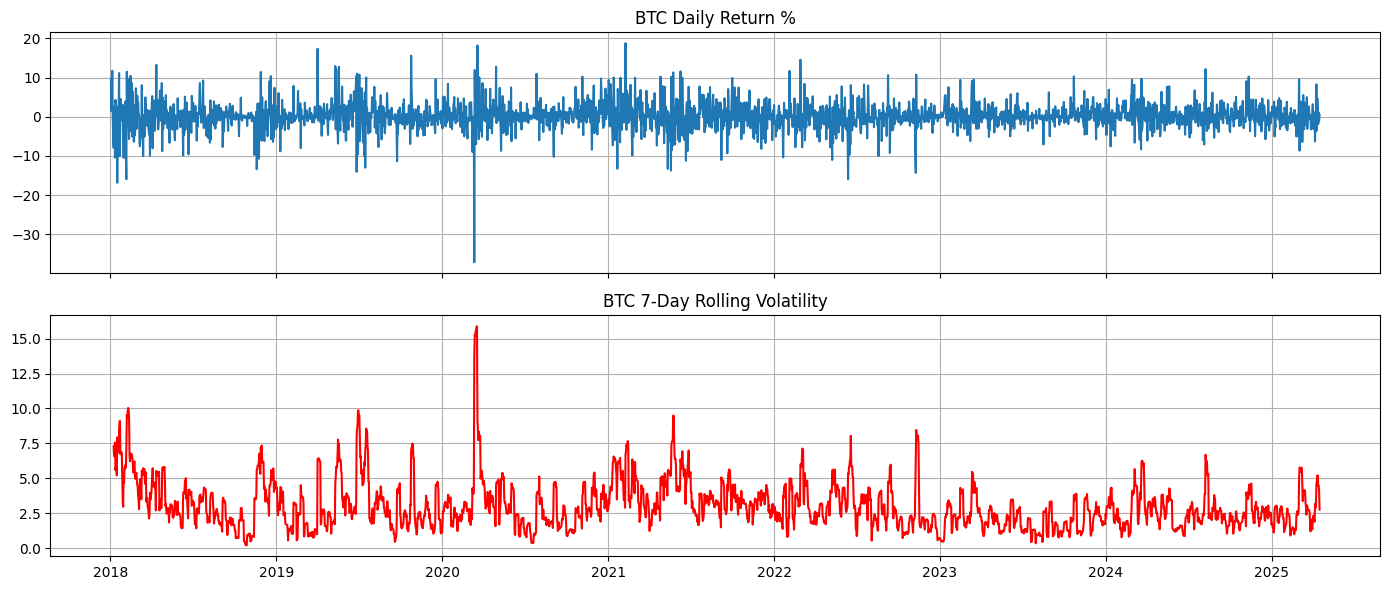

In [312]:
# Add Volatility & Returns

def plot_btc_returns_volatility(df):
    returns = df["Close"].pct_change() * 100
    vol = returns.rolling(7).std()

    fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    axs[0].plot(returns, label="Daily Return (%)")
    axs[0].set_title("BTC Daily Return %")
    axs[0].grid(True)

    axs[1].plot(vol, label="7-Day Volatility", color='red')
    axs[1].set_title("BTC 7-Day Rolling Volatility")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_btc_returns_volatility(btc_hist)

In [313]:
# Summary Stats

def btc_summary(df):
    stats = {
        "Start": df.index.min(),
        "End": df.index.max(),
        "Min Price": df["Close"].min(),
        "Max Price": df["Close"].max(),
        "Mean Price": df["Close"].mean(),
        "Median Price": df["Close"].median(),
        "Std Dev": df["Close"].std(),
        "Total Trading Days": len(df),
        "Missing Days": (df.index[-1] - df.index[0]).days - len(df)
    }
    return pd.Series(stats)
print(btc_summary(btc_hist))

Start                 2018-01-01 00:00:00+00:00
End                   2025-04-16 00:00:00+00:00
Min Price                           3236.761719
Max Price                         106146.265625
Mean Price                         30619.187926
Median Price                       23471.871094
Std Dev                            25060.770049
Total Trading Days                         2663
Missing Days                                 -1
dtype: object


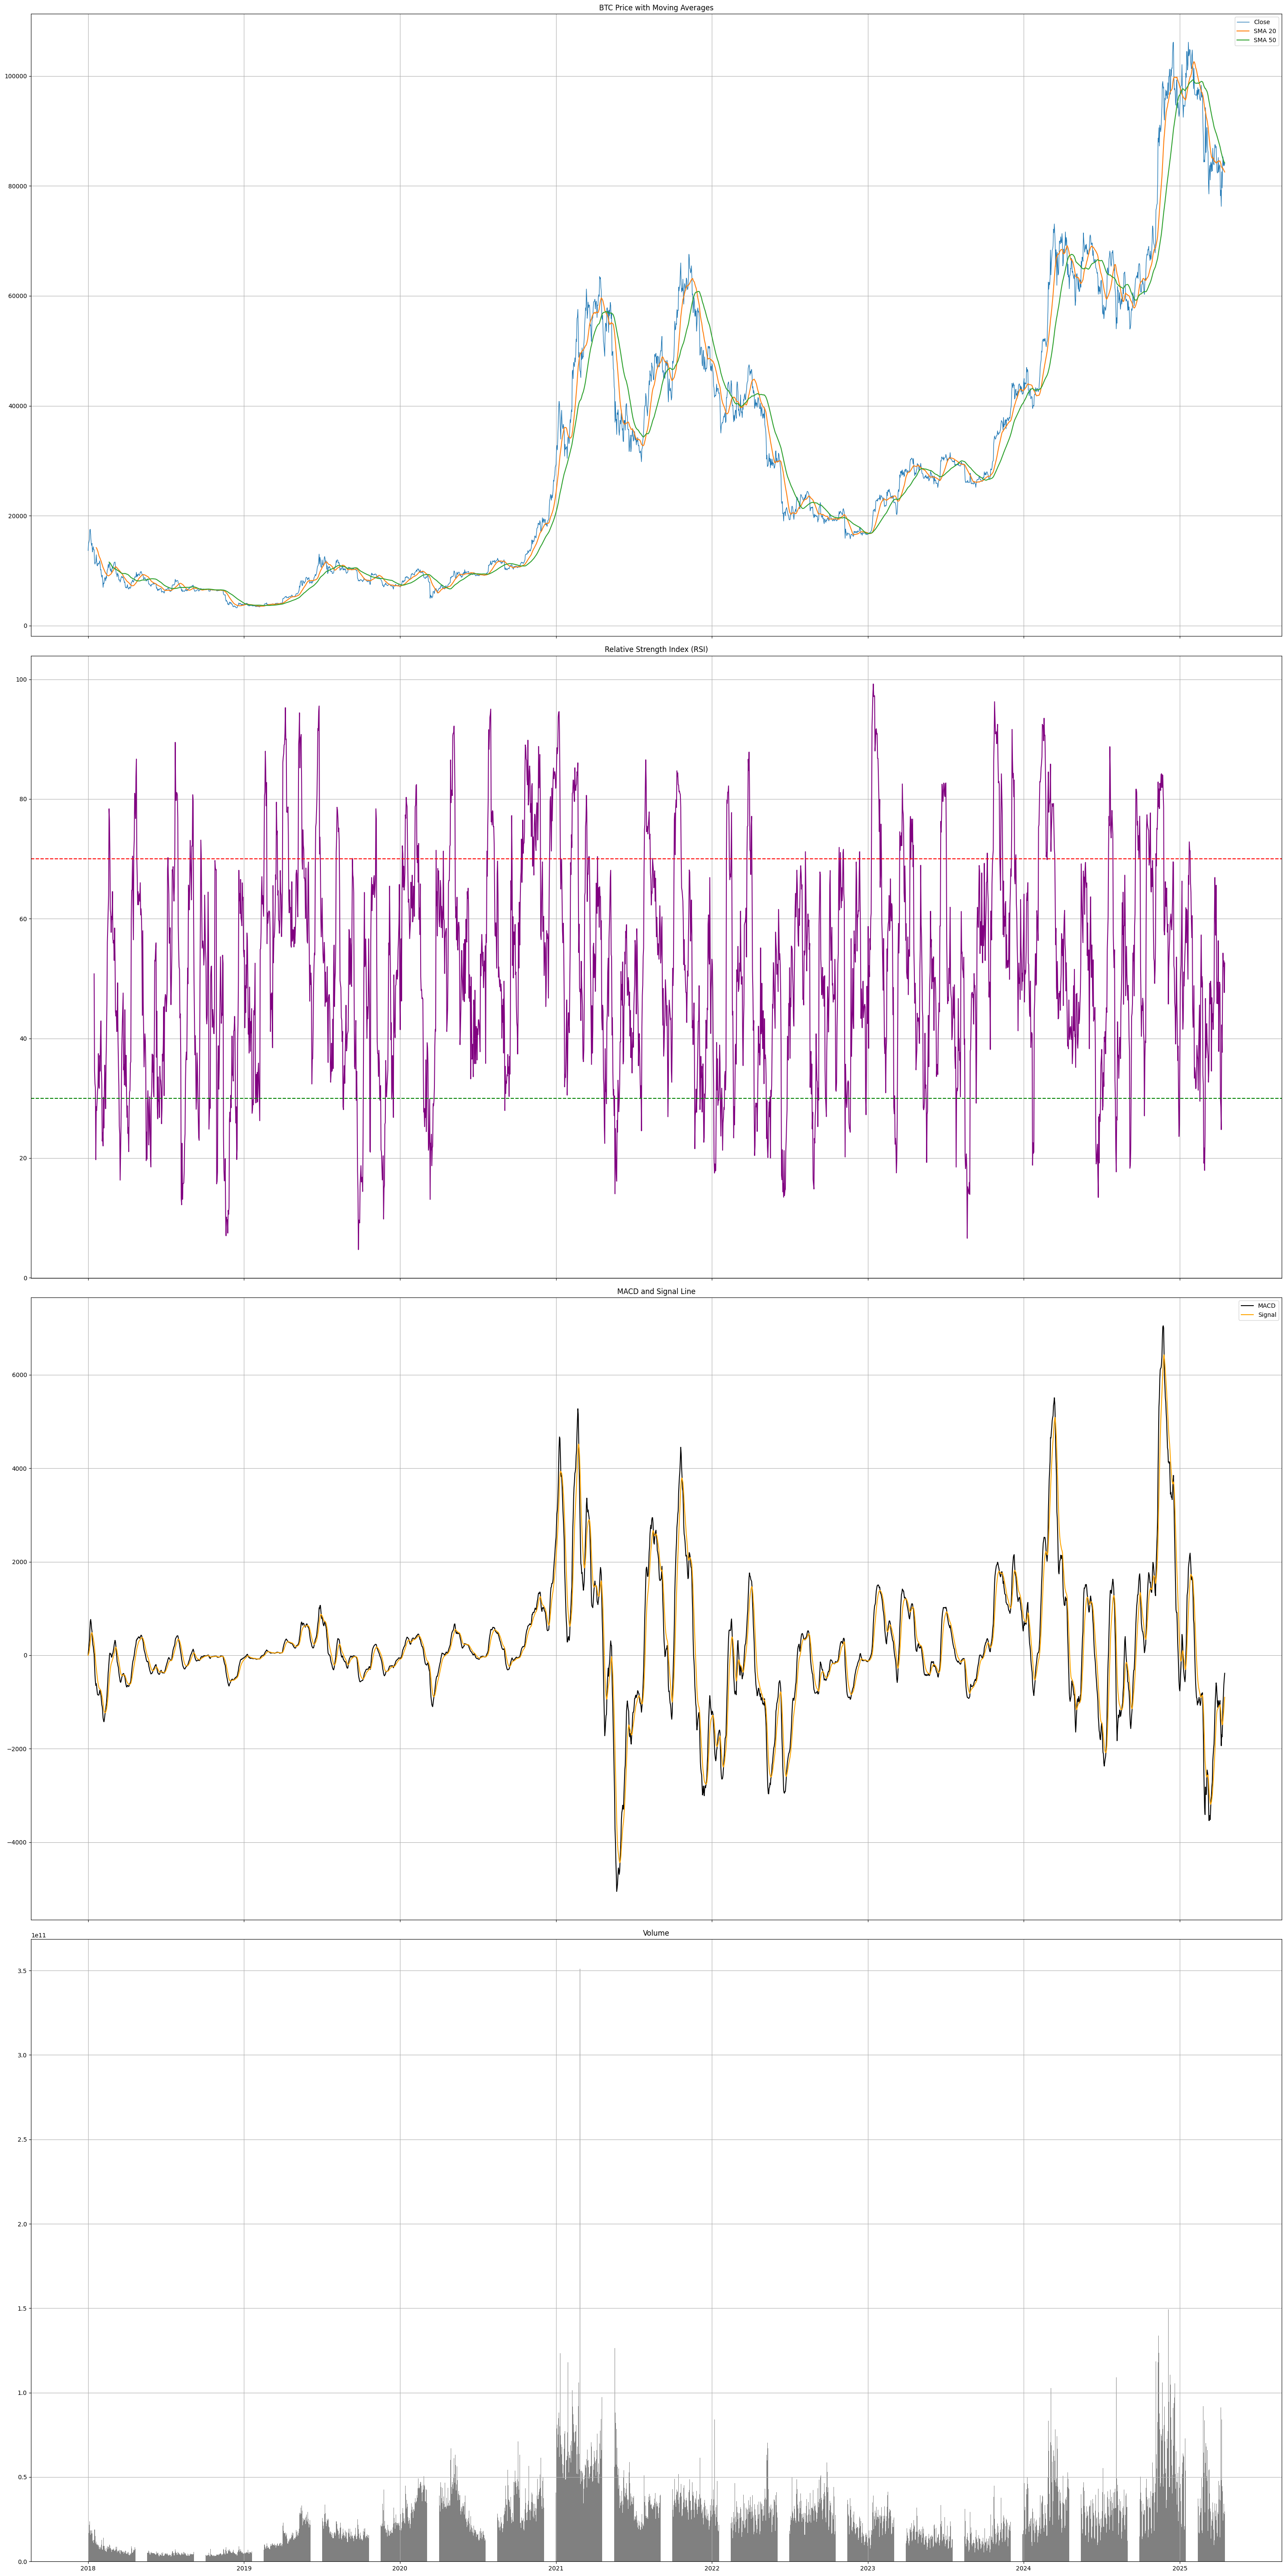

In [314]:
# Moving Averages (SMA & EMA)
def add_moving_averages(df, short=20, long=50):
    df["SMA_20"] = df["Close"].rolling(window=short).mean()
    df["SMA_50"] = df["Close"].rolling(window=long).mean()
    df["EMA_20"] = df["Close"].ewm(span=short, adjust=False).mean()
    return df

# RSI (Relative Strength Index)
def add_rsi(df, window=14):
    delta = df["Close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))
    return df

# MACD (Moving Average Convergence Divergence)
def add_macd(df, fast=12, slow=26, signal=9):
    ema_fast = df["Close"].ewm(span=fast, adjust=False).mean()
    ema_slow = df["Close"].ewm(span=slow, adjust=False).mean()
    df["MACD"] = ema_fast - ema_slow
    df["MACD_Signal"] = df["MACD"].ewm(span=signal, adjust=False).mean()
    return df

def plot_btc_tech_indicators(df):
    fig, axs = plt.subplots(4, 1, figsize=(30, 60), sharex=True)

    # Close + Moving Averages
    axs[0].plot(df["Close"], label="Close", linewidth=1)
    axs[0].plot(df["SMA_20"], label="SMA 20")
    axs[0].plot(df["SMA_50"], label="SMA 50")
    axs[0].set_title("BTC Price with Moving Averages")
    axs[0].legend()
    axs[0].grid(True)

    # RSI
    axs[1].plot(df["RSI"], label="RSI", color='purple')
    axs[1].axhline(70, color='red', linestyle='--')
    axs[1].axhline(30, color='green', linestyle='--')
    axs[1].set_title("Relative Strength Index (RSI)")
    axs[1].grid(True)

    # MACD
    axs[2].plot(df["MACD"], label="MACD", color='black')
    axs[2].plot(df["MACD_Signal"], label="Signal", color='orange')
    axs[2].set_title("MACD and Signal Line")
    axs[2].legend()
    axs[2].grid(True)

    # Volume
    axs[3].bar(df.index, df["Volume"], label="Volume", color='grey')
    axs[3].set_title("Volume")
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()


btc_hist = add_moving_averages(btc_hist)
btc_hist = add_rsi(btc_hist)
btc_hist = add_macd(btc_hist)
plot_btc_tech_indicators(btc_hist)


In [315]:
mlflow.tensorflow.autolog()

2025/04/18 18:04:20 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


In [316]:
def load_data():
    df = fetch_market_data(CRYPTO_SYMBOLS, START_DATE, END_DATE)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)
    feature_names = df.columns.tolist()
    return scaled, scaler, feature_names

In [317]:
scaled_data, scaler, feature_names = load_data()
print("Feature Names:", feature_names)
print("Scaled data shape:", scaled_data.shape)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Feature Names: ['BTC-USD_Close', 'BTC-USD_Volume', 'ETH-USD_Close', 'ETH-USD_Volume', 'LTC-USD_Close', 'LTC-USD_Volume', 'DOGE-USD_Close', 'DOGE-USD_Volume']
Scaled data shape: (2718, 8)


# --- Model Building ---

In [318]:
def build_model(input_shape, output_steps):
    """Build a convolutional LSTM encoder-decoder with attention for forecasting."""
    time_steps, features = input_shape
    # Encoder: Conv1D + Bidirectional LSTM
    inputs = Input(shape=(time_steps, features))
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal')(inputs)
    x = Dropout(0.2)(x)
    x = LayerNormalization()(x)
    x = tf.keras.layers.Bidirectional(
        LSTM(128, return_sequences=False)
    )(x)
    # Repeat encoded vector for decoder steps
    x = RepeatVector(output_steps)(x)
    # Decoder: LSTM + Attention
    x = LSTM(128, return_sequences=True)(x)
    attn_output = Attention()([x, x])
    x = tf.keras.layers.Add()([x, attn_output])
    # Output: one Dense per symbol per timestep
    outputs = TimeDistributed(Dense(len(CRYPTO_SYMBOLS)))(x)
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse',
        metrics=['mae']
    )
    return model

In [319]:
model = build_model((WINDOW_SIZE, scaled_data.shape[1]), FORECAST_HORIZON)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 50, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 50, 64)    │      1,600 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 50, 64)    │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 64)    │        128 │ dropout_9[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 256)       │    197,632 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 3, 256)    │          0 │ bidirectional_2[… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 3, 128)    │    197,120 │ repeat_vector_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_7         │ (None, 3, 128)    │          0 │ lstm_10[0][0],    │
│ (Attention)         │                   │            │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 3, 128)    │          0 │ lstm_10[0][0],    │
│                     │                   │            │ attention_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 3, 4)      │        516 │ add_7[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 396,996 (1.51 MB)

 Trainable params: 396,996 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [320]:
X, y = create_sequences(scaled_data, WINDOW_SIZE, FORECAST_HORIZON)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
print("Training samples:", X_train.shape, "Validation samples:", X_val.shape)

Training samples: (2132, 50, 8) Validation samples: (533, 50, 8)


Training Pipeline

In [ ]:
with mlflow.start_run():
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
        ],
        verbose=1
    )
    # Save model in native Keras format
    model.save(MODEL_PATH)
    mlflow.log_artifact(MODEL_PATH)

Epoch 1/200


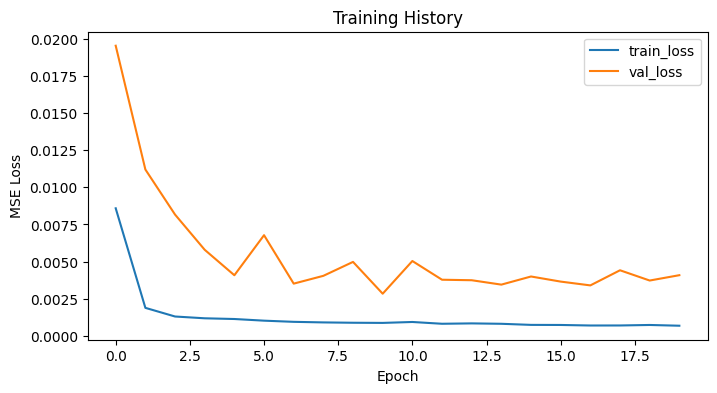

In [202]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training History')
plt.show()

In [203]:
y_pred = model.predict(X_val)
def plot_forecast(y_true, y_pred, idx):
    horizon = y_true.shape[1]
    plt.figure(figsize=(16,8))
    for i, sym in enumerate(CRYPTO_SYMBOLS):
        plt.plot(range(horizon), y_true[idx,:,i], 'b--', label=f"True {sym}")
        plt.plot(range(horizon), y_pred[idx,:,i], 'r-', label=f"Pred {sym}")
    plt.title(f"Forecast vs Actual (Sample {idx})")
    plt.xlabel('Days Ahead')
    plt.legend()
    plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


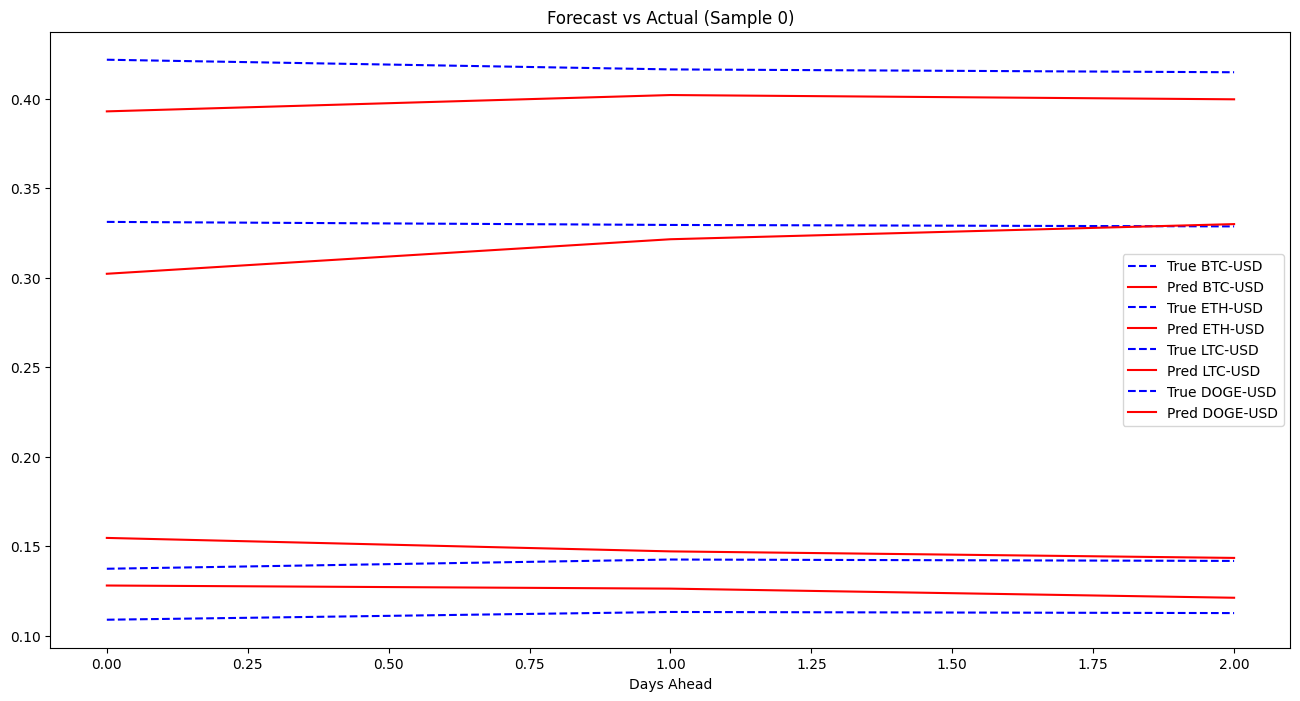

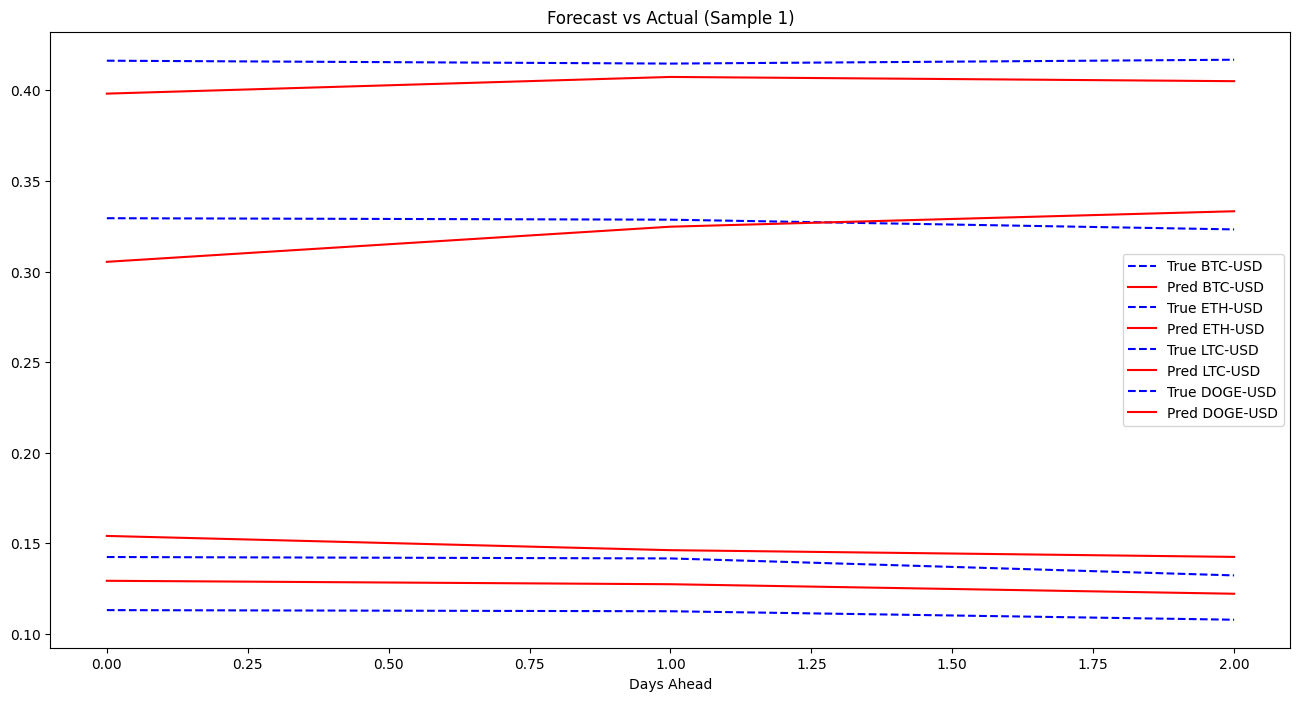

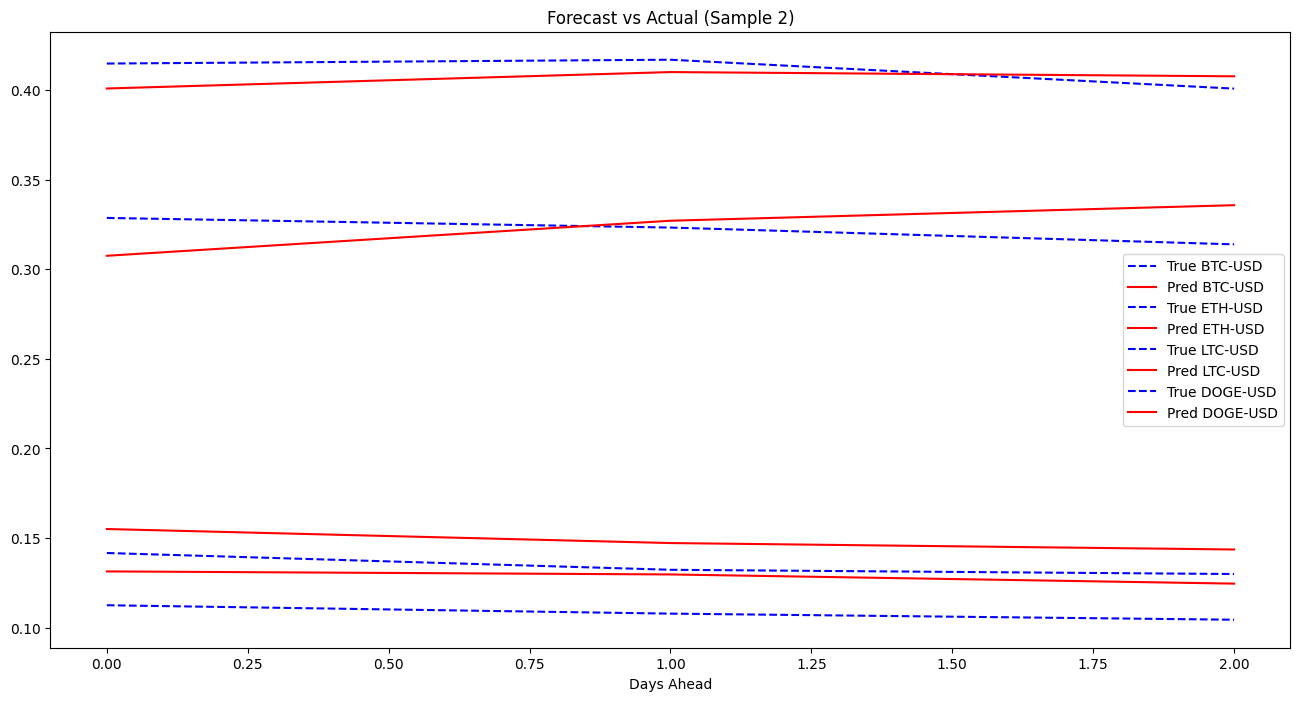

In [204]:
for i in range(3):
    plot_forecast(y_val, y_pred, i)

In [205]:
print("Saving model to", MODEL_DIR)

Saving model to ../models/model.keras


In [206]:
model = tf.keras.models.load_model(MODEL_DIR)

D:\Projects\CoinPilot\coinpilot_model\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [207]:
recent_df = fetch_market_data(
    CRYPTO_SYMBOLS,
    (pd.to_datetime(END_DATE) - pd.Timedelta(days=WINDOW_SIZE)).strftime('%Y-%m-%d'),
    END_DATE
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [208]:
# Scale using the same scaler
scaled_recent = scaler.transform(recent_df)
# Prepare input sequence
latest_seq = np.expand_dims(scaled_recent[-WINDOW_SIZE:], axis=0)

In [209]:
# Predict scaled prices for next FORECAST_HORIZON days
pred_scaled = model.predict(latest_seq)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


In [210]:
# Inverse transform predictions to original scale
# We only predicted close prices; build dummy array to inverse transform
feature_count = len(feature_names)
target_indices = [i * 2 for i in range(len(CRYPTO_SYMBOLS))]
dummy = np.zeros((FORECAST_HORIZON, feature_count))
dummy[:, target_indices] = pred_scaled
pred_inv = scaler.inverse_transform(dummy)[:, target_indices]

In [211]:
# Build DataFrame of future predictions
future_dates = pd.date_range(
    start=pd.to_datetime(END_DATE) + pd.Timedelta(days=1),
    periods=FORECAST_HORIZON,
    freq='D'
)
pred_df = pd.DataFrame(pred_inv, columns=CRYPTO_SYMBOLS, index=future_dates)

print("Predicted prices for the next", FORECAST_HORIZON, "days:")
display(pred_df)

Predicted prices for the next 3 days:


,BTC-USD,ETH-USD,LTC-USD,DOGE-USD
2025-04-19,73201.724431,2127.121897,114.551379,0.179161
2025-04-20,81180.681291,2038.267030,110.375996,0.188508
2025-04-21,86291.225241,1966.968152,108.685714,0.192879
